<a href="https://colab.research.google.com/github/ozturksila/3D-Object-Classification/blob/main/3D_Object_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install torchmetrics
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.3/671.3 KB 12.0 MB/s eta 0:00:00


## Libiraries

In [10]:
import os
import glob
import trimesh
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix
from torchvision.datasets.utils import download_and_extract_archive


import scipy
from scipy.ndimage import rotate

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import time
import copy

#Download DataSet

In [11]:
%%capture
!wget https://www.dropbox.com/s/ja56cvf3x4mkf1t/modelnet10_voxelized_32.npz

In [12]:
filename = 'ModelNet10'
root = '~/tmp/'
download_and_extract_archive('http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip', root, filename)

  0%|          | 0/473402300 [00:00<?, ?it/s]

Extracting /root/tmp/ModelNet10.zip to ModelNet10


In [13]:
DATA_DIR = 'ModelNet10/ModelNet10/'

#Data Visualization

In [14]:
mesh = trimesh.load(os.path.join(DATA_DIR, "monitor/train/monitor_0377.off"))
mesh.show()

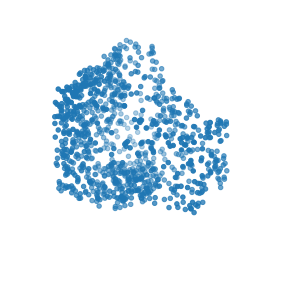

In [15]:
points = mesh.sample(1024)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()


In [16]:
vox = mesh.voxelized(5.0)
vox

<trimesh.VoxelGrid(35, 25, 23)>

In [17]:
vox = vox.revoxelized((32,32,32)).matrix.astype(int)

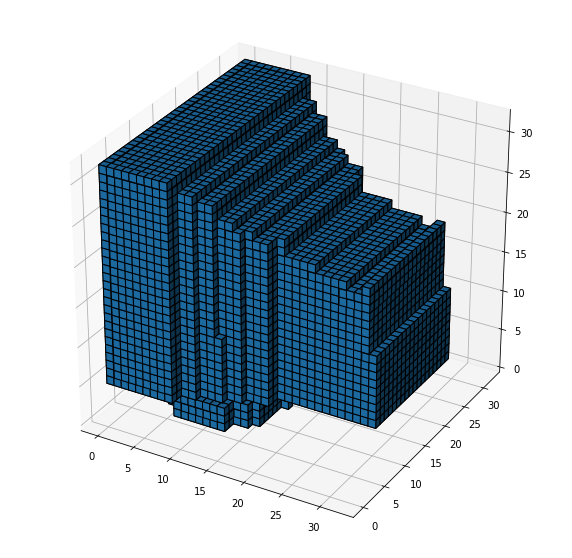

In [18]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(vox, edgecolor='k')
plt.show()

#Functions

##Confusion Matrix

In [19]:
def accurancy_per_class (conf_matrix, class_names):
    per_class_accuracy = 100 * torch.diag(conf_matrix) / torch.sum(conf_matrix, 1)
    tmp = {}
    for i, x in enumerate(class_names):
        tmp[x] = per_class_accuracy[i].item()
    print({"per class accuracy": tmp})

In [20]:
def create_matrix (conf_matrix, class_names ):
    fig = plt.figure(figsize = (12,7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names, rotation=0)
    plt.title("Confusion Matrix")
    accurancy_per_class(conf_matrix,class_names)

## Accurancy & Loss History

In [21]:
def smooth(x, w=0.95):
    last = x[0]
    smoothed = []
    for point in x:
        smoothed_val = w * last + (1 - w) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
        
    return smoothed

In [22]:
def accurancy_and_loss_history (history ):
    eps = range(0, len(history["train_loss"].cpu()))

    sns.set_theme()
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle('Results')

    ax[0].plot(eps, history["train_loss"].cpu(), 'g', label='Training Loss')
    ax[0].plot(eps, history["valid_loss"].cpu(), 'b', label='Valid Loss')
    ax[0].set_title('Loss History')
    ax[0].set(xlabel='Epochs', ylabel='Loss')
    ax[0].legend()

    ax[1].plot(eps, history["train_acc"].cpu(), 'g', label='Training Accuracy')
    ax[1].plot(eps, history["valid_acc"].cpu(), 'b', label='Valid Accuracy')
    ax[1].set_title('Accuracy History')
    ax[1].set(xlabel='Epochs', ylabel='Accuracy')
    ax[1].legend()

## Weight Histograms

In [23]:
def model_weights(model, t_cnn):
    # First hidden layer
    h1_w = model.conv3d_1.weight.data.cpu().numpy()
    h1_b = model.conv3d_1.bias.data.cpu().numpy()

    # Second hidden layer
    h2_w = model.conv3d_2.weight.data.cpu().numpy()
    h2_b = model.conv3d_2.bias.data.cpu().numpy()

    if t_cnn ==4:
      # Third hidden layer
      h3_w = model.conv3d_3.weight.data.cpu().numpy()
      h3_b = model.conv3d_3.bias.data.cpu().numpy()

      # Fouth hidden layer
      h4_w = model.conv3d_4.weight.data.cpu().numpy()
      h4_b = model.conv3d_4.bias.data.cpu().numpy()

    # Fifth hidden layer
    h5_w = model.fc1.weight.data.cpu().numpy()
    h5_b = model.fc1.bias.data.cpu().numpy()

    # Output layer
    out_w = model.fc2.weight.data.cpu().numpy()
    out_b = model.fc2.bias.data.cpu().numpy()

    # Weights histogram

    
    if t_cnn ==4:
      fig, axs = plt.subplots(6, 1, figsize=(12,8))
      axs[0].hist(h1_w.flatten(), 50)
      axs[0].set_title('First hidden layer weights')
      axs[1].hist(h2_w.flatten(), 50)
      axs[1].set_title('Second hidden layer weights')
      axs[2].hist(h3_w.flatten(), 50)
      axs[2].set_title('Third layer weights')
      axs[3].hist(h4_w.flatten(), 50)
      axs[3].set_title('Fourth layer weights')
      axs[4].hist(h5_w.flatten(), 50)
      axs[4].set_title('Fifth layer weights')
      axs[5].hist(out_w.flatten(), 50)
      axs[5].set_title('Output layer weights')
    else:
      fig, axs = plt.subplots(4, 1, figsize=(12,8))
      axs[0].hist(h1_w.flatten(), 50)
      axs[0].set_title('First hidden layer weights')
      axs[1].hist(h2_w.flatten(), 50)
      axs[1].set_title('Second hidden layer weights')
      axs[2].hist(h5_w.flatten(), 50)
      axs[2].set_title('Fifth layer weights')
      axs[3].hist(out_w.flatten(), 50)
      axs[3].set_title('Output layer weights')
    [ax.grid() for ax in axs]
    plt.tight_layout()
    plt.show()

##Visualize Model

In [24]:
def visualize_model(model, test_dataloader,class_names,num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig =  plt.figure(figsize=(30, 15))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                mesh =inputs.cpu().data[j]
                images_so_far += 1
                ax = fig.add_subplot(2,5,images_so_far,projection='3d',)
                ax.voxels(mesh[0], edgecolor='k')
                ax.axis('off')
                if class_names[labels[j]]!=class_names[preds[j]]:
                  ax.set_title(f'class: {class_names[labels[j]]} \n predicted: {class_names[preds[j]]}', loc="center",color='red')
                else:
                  ax.set_title(f'class: {class_names[labels[j]]} \n predicted: {class_names[preds[j]]}', loc="center",color='green')
                
                

                if images_so_far == num_images:
                    plt.show()
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#DataSet

In [25]:
class VoxelDataset(Dataset):
    
    def __init__(self,augment=True, train = True):

        self.augment=augment
        if train:
            tmp = np.load("modelnet10_voxelized_32.npz")
            self.data = tmp["X_train"]
            self.label = tmp["Y_train"]
            del tmp
        else:
            tmp = np.load("modelnet10_voxelized_32.npz")
            self.data = tmp["X_test"]
            self.label = tmp["Y_test"]
            del tmp
                
    def __len__(self):
      return len(self.label)

    def __preproc__(self, voxels):
        
        #flip x
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=0)
        
        #flip y
        if np.random.randint(2):
            voxels = np.flip(voxels, axis=1)
        
        return voxels.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        if self.augment :
          voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

#Voxnet





##Load Data

In [24]:
train_ds = VoxelDataset(train=True)
test_ds = VoxelDataset(train=False)
train_ds.data[0].shape

(32, 32, 32)

In [25]:
train_dataloader = DataLoader(dataset=train_ds, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(dataset=test_ds, batch_size=128)

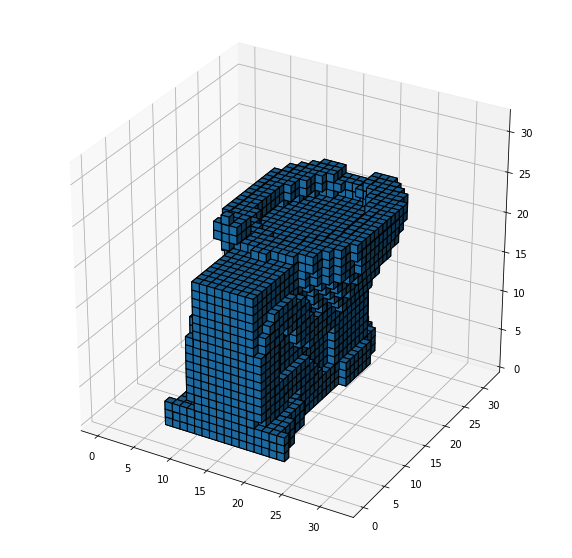

In [26]:
mesh = next(iter(train_dataloader))
mesh = mesh[0][0][0]
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(mesh, edgecolor='k')
plt.show()

## HyperParameters

In [27]:
learning_rate = 0.1
data_size = 32
sgd_momentum = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 60
lr_scheduler_step = 60
lr_scheduler_gamma = 0.5
print_epoch_rate = 1
verbose= 1

In [30]:
batch_size = 512

## Model Network

In [31]:
class VoxelNet(nn.Module):
    def __init__(self,dropout,f1,f2,fc_1, n_classes=10, data_size=32):
        super().__init__()
        self.n_classes = n_classes
        self.data_size = data_size
        self.dropout=dropout
        self.f1 = f1
        self.f2 = f2
        self.fc_1 = fc_1
        
        #features
        self.conv3d_1 = nn.Conv3d(in_channels=1, out_channels=self.f1, kernel_size=5, stride=2)
        self.dropout1 = nn.Dropout(p=self.dropout)
        self.conv3d_2 = nn.Conv3d(in_channels=self.f1, out_channels=self.f2, kernel_size=3)
        self.dropout2 = nn.Dropout(p=self.dropout)
        self.maxpool = nn.MaxPool3d(2)
        
        
        
        if data_size==64:
            dim=351232
            351232
        else:
           dim=27648
            
        #calculate dim after pooling for fc layer
        x = torch.rand((1,1,data_size,data_size,data_size))
        #x = F.leaky_relu(self.conv3d_1(x))
        #x= F.relu6(self.conv3d_1(x))
        x= F.relu(self.conv3d_1(x))
        x = self.dropout1(x)
        #x = F.relu(self.conv3d_2(x))
        #x= F.relu6(self.conv3d_2(x))
        x= F.relu(self.conv3d_2(x))
        x = self.dropout2(x)
        x = self.maxpool(x)
        print(x.shape)
        dim = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3] * x.shape[4]

        
        #mlp
        self.fc1 = nn.Linear(dim, fc_1)
        self.dropout3 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(self.fc_1, self.n_classes)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        #features
        #x = F.leaky_relu(self.conv3d_1(x))
        #x=F.relu6(self.conv3d_1(x))
        x=F.relu(self.conv3d_1(x))
        x = self.dropout1(x)
        #x = F.leaky_relu(self.conv3d_2(x))
        #x=F.relu6(self.conv3d_2(x))
        x=F.relu(self.conv3d_2(x))
        x = self.dropout2(x)

        #maxpool
        x = self.maxpool(x)
        
        #flatten
        x = x.view(x.size(0), -1)
        
        #mlp
        #x = F.leaky_relu(self.fc1(x))
        #x = F.relu6(self.fc1(x))
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        
        return self.logsoftmax(x)

In [32]:
model = VoxelNet(dropout = 0.2,f1= 64,f2 =64,fc_1=64, data_size=32)

torch.Size([1, 64, 6, 6, 6])


In [33]:
class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
num_classes = len(class_names)

##Optimizer & Loss Fucntion

In [34]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_momentum)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=lr_scheduler_gamma)
loss_func = nn.NLLLoss()

##Training

In [35]:
train_loss_history, valid_loss_history = [], []
train_acc_history, valid_acc_history = [], []

train_accuracy = Accuracy(task='multiclass', num_classes=10)
valid_accuracy = Accuracy(task='multiclass', num_classes=10)

print("started training...\n")

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
total_time = time.time()
for epoch in range(0, epochs):            
    t = time.time()

    train_loss = []                                                         #track training loss
    valid_loss = []                                                         #track valid loss
    
    #track loss for 10 batch
    batch_loss=0
    
    #training on batches
    model.train()
    for i, data in enumerate(train_dataloader, 0):
        x, y = data[0].to(device), data[1].to(device)                        #send to device
        optimizer.zero_grad()
        pred = model(x)                                                      #predict class
        loss = loss_func(pred, y)                                            #compute and track loss
        train_loss.append(loss.cpu().data)                                   #track loss
        acc = train_accuracy(torch.argmax(pred, 1).cpu(), y.cpu())           #track accuracy
        
        #back propagate and optimize
        loss.backward()
        optimizer.step()
        if lr_scheduler != None:
          lr_scheduler.step()
        
    pred_conf = []                                                           #track for confusion matrix
    y_conf = []                                                              #track for confusion matrix
    
    
    #validation on batches
    model.eval()
    for x, y in test_dataloader:
        x, y = x.to(device), y.to(device)                                       #send to device
        pred = model(x)                                                         #predict class
        loss = loss_func(pred, y)                                               #compute and track loss
        valid_loss.append(loss.cpu().data)                                      #track loss
        valid_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())             #track accuracy
        pred_conf.append(torch.argmax(pred, 1))
        y_conf.append(y)
        

    
    # total accuracy over all batches
    total_train_accuracy = train_accuracy.compute()
    total_valid_accuracy = valid_accuracy.compute()
    train_accuracy.reset()
    valid_accuracy.reset()
    
    #track loss and acc for plotting
    train_loss_history.append(torch.mean(torch.tensor(train_loss)))
    valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
    train_acc_history.append(total_train_accuracy)
    valid_acc_history.append(total_valid_accuracy)
    if total_valid_accuracy > best_acc:
        best_acc = total_valid_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        #compute confusion matrix
        a = torch.cat(pred_conf).cpu()
        b = torch.cat(y_conf).cpu()
        confmat = ConfusionMatrix(task='multiclass', num_classes=10)
        conf_matrix = confmat(a, b)



    elapsed_time_epoch = time.time() - t   
            
    

    tmp1 = "epoch:{:3d}/{:3d}".format(epoch+1, epochs)
    tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
    tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
    tmp4 = "time: {:.2f} seconds".format(elapsed_time_epoch)
    print(tmp1, tmp2, tmp3, tmp4)
        
    
    print({"train loss": train_loss_history[epoch], "epoch": epoch})
    print({"valid loss": valid_loss_history[epoch], "epoch": epoch})
    print({"train accuracy": train_acc_history[epoch].item(), "epoch": epoch})
    print({"valid accuracy": valid_acc_history[epoch].item(), "epoch": epoch})
    
    
    
#save history
history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), \
          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}

elapsed_time_training = time.time() - total_time   
#print end results

print("finished training\n")
idc = torch.argmax(torch.tensor(valid_acc_history)).item()
print("time: {:.2f} seconds".format(elapsed_time_training))
print("time: {:.2f} minutes".format(elapsed_time_training/60))
print("Avg Time Per Epoch {:.2f} seconds".format(elapsed_time_training/epochs))
print("Best Val Acc: {:.2%}".format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)
        
        
    


        
        
    

started training...

epoch:  1/ 60 train-loss: 1.99, train-acc: 38.33% valid-loss: 1.34, valid-acc: 57.16% time: 135.98 seconds
{'train loss': tensor(1.9869), 'epoch': 0}
{'valid loss': tensor(1.3360), 'epoch': 0}
{'train accuracy': 0.3833165466785431, 'epoch': 0}
{'valid accuracy': 0.5715858936309814, 'epoch': 0}
epoch:  2/ 60 train-loss: 1.02, train-acc: 68.70% valid-loss: 0.82, valid-acc: 70.59% time: 134.75 seconds
{'train loss': tensor(1.0229), 'epoch': 1}
{'valid loss': tensor(0.8187), 'epoch': 1}
{'train accuracy': 0.6869959831237793, 'epoch': 1}
{'valid accuracy': 0.7059471607208252, 'epoch': 1}
epoch:  3/ 60 train-loss: 0.62, train-acc: 80.27% valid-loss: 0.55, valid-acc: 80.18% time: 135.58 seconds
{'train loss': tensor(0.6232), 'epoch': 2}
{'valid loss': tensor(0.5463), 'epoch': 2}
{'train accuracy': 0.8026713728904724, 'epoch': 2}
{'valid accuracy': 0.8017621040344238, 'epoch': 2}
epoch:  4/ 60 train-loss: 0.45, train-acc: 85.79% valid-loss: 0.48, valid-acc: 85.13% time: 13

<All keys matched successfully>

##Results

###Confusion Matrix

{'per class accuracy': {'bathtub': 74.0, 'bed': 98.0, 'chair': 100.0, 'desk': 77.90697479248047, 'dresser': 80.23255920410156, 'monitor': 98.0, 'night_stand': 74.4186019897461, 'sofa': 94.0, 'table': 86.0, 'toilet': 96.0}}


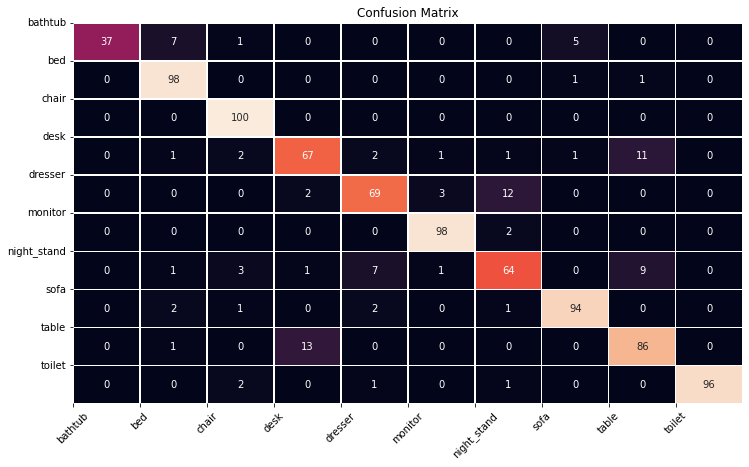

In [36]:
create_matrix(conf_matrix,class_names)

###History

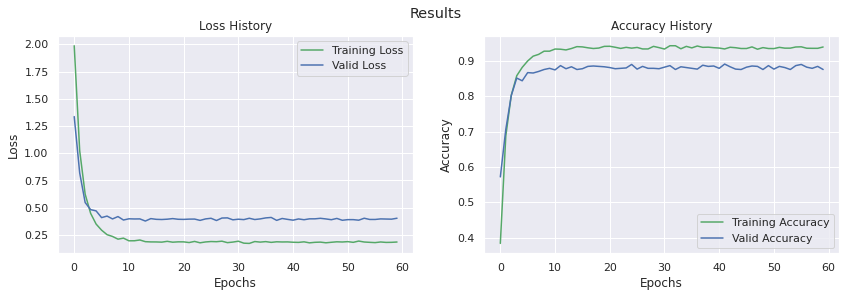

In [37]:
accurancy_and_loss_history(history)

### Weight Histograms

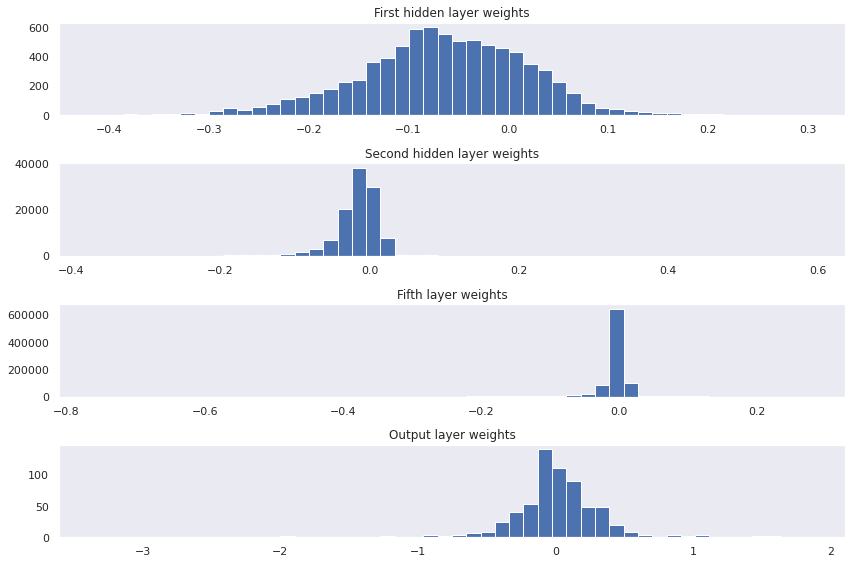

In [38]:
model_weights(model,2)

###Model Visualize

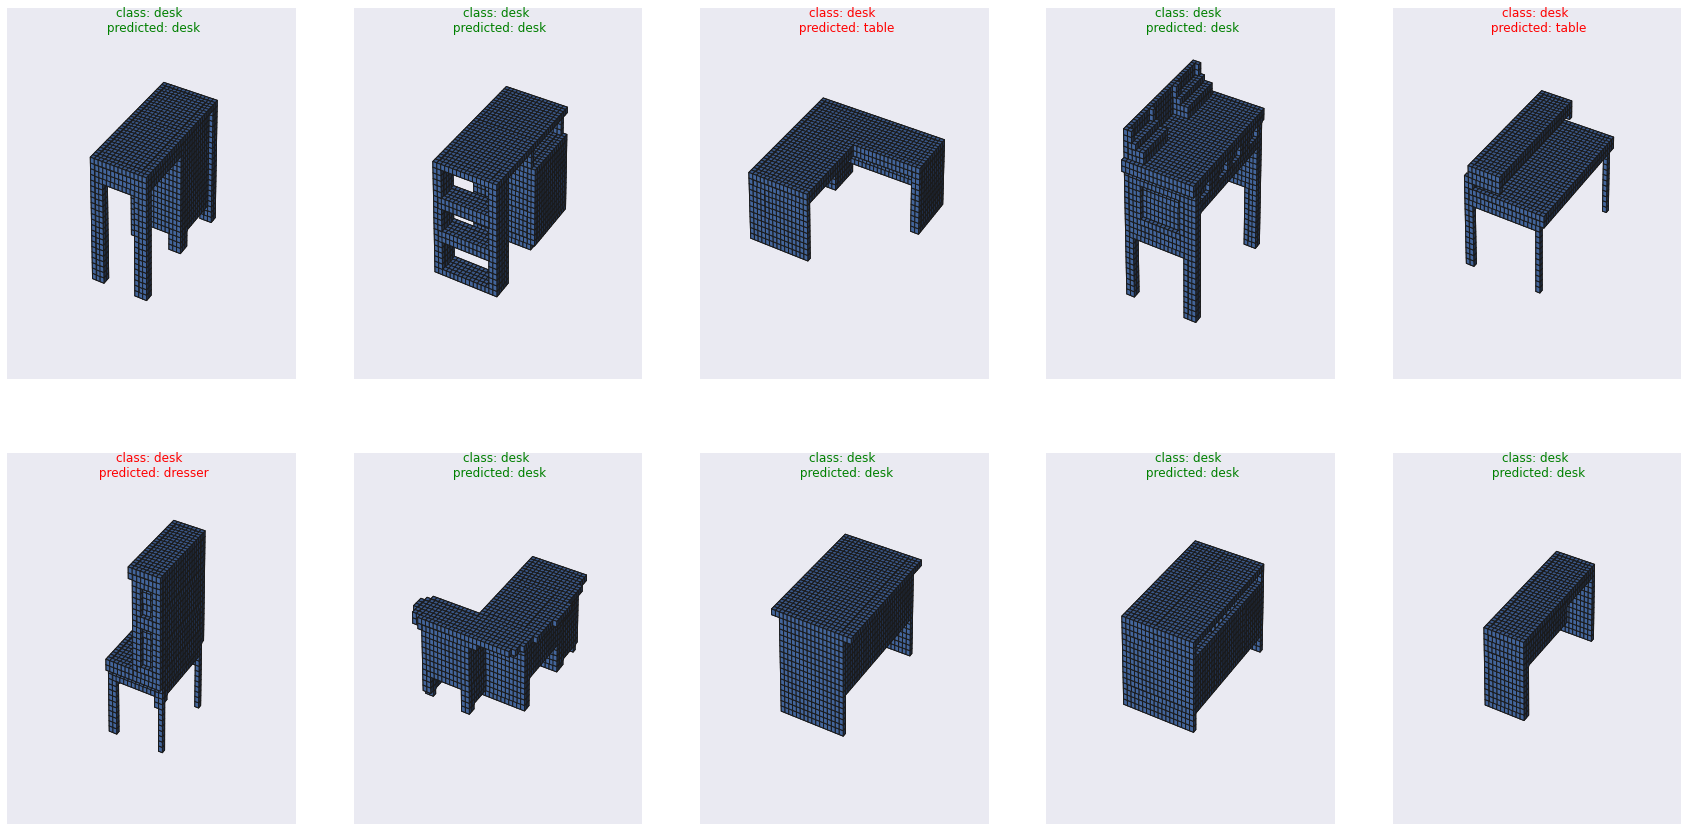

In [39]:
visualize_model(model, test_dataloader, class_names)

###Classification Report

In [40]:
print(classification_report(b,a, target_names =class_names))

              precision    recall  f1-score   support

     bathtub       1.00      0.74      0.85        50
         bed       0.89      0.98      0.93       100
       chair       0.92      1.00      0.96       100
        desk       0.81      0.78      0.79        86
     dresser       0.85      0.80      0.83        86
     monitor       0.95      0.98      0.97       100
 night_stand       0.79      0.74      0.77        86
        sofa       0.93      0.94      0.94       100
       table       0.80      0.86      0.83       100
      toilet       1.00      0.96      0.98       100

    accuracy                           0.89       908
   macro avg       0.89      0.88      0.88       908
weighted avg       0.89      0.89      0.89       908



#Orion Implemetntaion

##Load Data

In [36]:
def load_data(batch_size, augment):
    train_ds = VoxelDataset(augment= augment, train=True)
    test_ds = VoxelDataset(augment=augment,train=False)
    train_ds.data[0].shape
    train_dataloader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = DataLoader(dataset=test_ds, batch_size=batch_size)
    return train_dataloader,test_dataloader

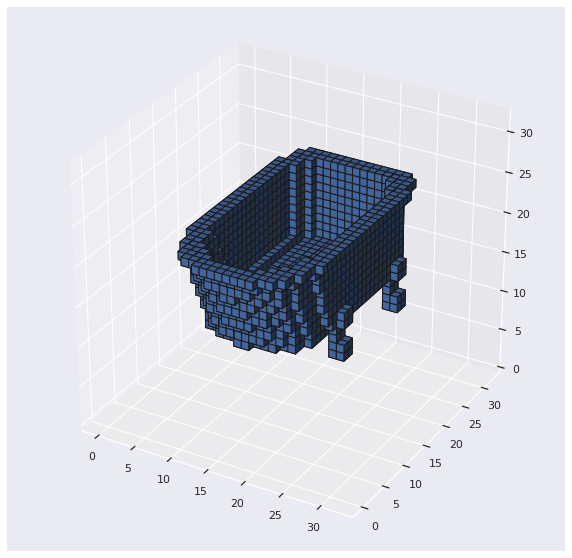

In [46]:
train_dataloader, test_dataloader = load_data(512, True)
mesh = next(iter(train_dataloader))
mesh = mesh[0][0][0]
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.voxels(mesh, edgecolor='k')
plt.show()

## Model Network 

In [47]:
class Orion(nn.Module):
    def __init__(self,f1,f2,f3,f4,fc_1,p, n_classes=10, data_size=32):
        super().__init__()
        self.n_classes = n_classes
        self.data_size = data_size
        self.f1 = f1
        self.f2 = f2
        self.f3=  f3
        self.f4=  f4
        self.fc_1 = fc_1
        self.p = p  # dropout ratios
        
        #features
        self.conv3d_1 = nn.Conv3d(in_channels=1, out_channels=self.f1, kernel_size=(3,3,3), stride=2,padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(self.f1)
        self.dropout1 = nn.Dropout(p=self.p[0])
        self.avgpool1 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))


        self.conv3d_2 = nn.Conv3d(in_channels=self.f1, out_channels=self.f2, kernel_size=(3,3,3), stride=1, padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(self.f2)
        self.dropout2 = nn.Dropout(p=self.p[1])
        self.avgpool2 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
       
        self.conv3d_3 = nn.Conv3d(in_channels=f2, out_channels=self.f3, kernel_size=(3,3,3), stride=1, padding=(1, 1, 1))       
        self.bn3 = nn.BatchNorm3d(self.f3)
        self.dropout3 = nn.Dropout(p=self.p[2])
        self.avgpool3 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        
        self.conv3d_4 = nn.Conv3d(in_channels=self.f3, out_channels=self.f4, kernel_size=(3,3,3), stride=1,padding=(1, 1, 1))
        self.bn4 = nn.BatchNorm3d(self.f4)
        self.dropout4 = nn.Dropout(p=self.p[3])
        
        self.avgpool4 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        
        
        if data_size==64:
            dim=351232
            351232
        else:
           dim=27648
            
        #calculate dim after pooling for fc layer
        x = torch.rand((1,1,data_size,data_size,data_size))
        x =self.conv3d_1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
        x = self.avgpool1(x)

        x=self.conv3d_2(x)
        x = self.bn2(x)
        x= F.leaky_relu(x)
        x = self.dropout2(x)
        x = self.avgpool2(x)

        x = self.conv3d_3(x)
        x = self.bn3(x)
        x= F.leaky_relu(x)
        x = self.dropout3(x)
        x = self.avgpool3(x)

        x = self.conv3d_4(x)
        x = self.bn4(x)
        x= F.leaky_relu(x)
        x = self.dropout4(x)

        x = self.avgpool4(x)
        dim = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3] * x.shape[4]
        
        #mlp
        self.fc1 = nn.Linear(dim, fc_1)
        self.dropout5 = nn.Dropout(p=self.p[4])
        self.fc2 = nn.Linear(self.fc_1, self.n_classes)
        #self.logsoftmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        #features
        x = self.bn1(self.conv3d_1(x))
        x= F.rrelu(x)
        x = self.dropout1(x)
        x = self.avgpool1(x)

        x = self.bn2(self.conv3d_2(x))
        x= F.leaky_relu(x)
        x = self.dropout2(x)
        x = self.avgpool2(x)

        x = self.bn3(self.conv3d_3(x))
        x= F.leaky_relu(x)
        x = self.dropout3(x)
        x = self.avgpool3(x)

        x = self.bn4(self.conv3d_4(x))
        x= F.leaky_relu(x)
        x = self.dropout4(x)
        x = self.avgpool4(x)
        
        #flatten
        x = x.view(x.size(0), -1)
        
        #mlp

        x= F.leaky_relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)
        
        return x

##Trainig

In [41]:
class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
num_classes = len(class_names)

In [42]:
def train (model, epochs,loss_func, optimizer,  train_dataloader, test_dataloader,lr_scheduler):
  train_loss_history, valid_loss_history = [], []
  train_acc_history, valid_acc_history = [], []

  train_accuracy = Accuracy(task='multiclass', num_classes=10)
  valid_accuracy = Accuracy(task='multiclass', num_classes=10)

  print("started training...\n")

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  total_time = time.time()
  for epoch in range(0, epochs):            
      t = time.time()

      train_loss = []                                                         #track training loss
      valid_loss = []                                                         #track valid loss
      
      #track loss for 10 batch
      batch_loss=0
      
      #training on batches
      model.train()
      for i, data in enumerate(train_dataloader, 0):
          x, y = data[0].to(device), data[1].to(device)                        #send to device
          optimizer.zero_grad()
          pred = model(x)                                                      #predict class
          loss = loss_func(pred, y)                                            #compute and track loss
          train_loss.append(loss.cpu().data)                                   #track loss
          acc = train_accuracy(torch.argmax(pred, 1).cpu(), y.cpu())           #track accuracy
          
          #back propagate and optimize
          loss.backward()
          optimizer.step()
          lr_scheduler.step()
          
      pred_conf = []                                                           #track for confusion matrix
      y_conf = []                                                              #track for confusion matrix
      
      
      #validation on batches
      model.eval()
      for x, y in test_dataloader:
          x, y = x.to(device), y.to(device)                                       #send to device
          pred = model(x)                                                         #predict class
          loss = loss_func(pred, y)                                               #compute and track loss
          valid_loss.append(loss.cpu().data)                                      #track loss
          valid_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())             #track accuracy
          pred_conf.append(torch.argmax(pred, 1))
          y_conf.append(y)
          
      
      
      # total accuracy over all batches
      total_train_accuracy = train_accuracy.compute()
      total_valid_accuracy = valid_accuracy.compute()
      train_accuracy.reset()
      valid_accuracy.reset()
      
      #track loss and acc for plotting
      train_loss_history.append(torch.mean(torch.tensor(train_loss)))
      valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
      train_acc_history.append(total_train_accuracy)
      valid_acc_history.append(total_valid_accuracy)
      if total_valid_accuracy > best_acc:      
        best_acc = total_valid_accuracy
        best_model_wts = copy.deepcopy(model.state_dict())
        #compute confusion matrix
        a = torch.cat(pred_conf).cpu()
        b = torch.cat(y_conf).cpu()
        confmat = ConfusionMatrix(task='multiclass', num_classes=10)
        conf_matrix = confmat(a, b)



      elapsed_time_epoch = time.time() - t   
              
      

      tmp1 = "epoch:{:3d}/{:3d}".format(epoch+1, epochs)
      tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
      tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
      tmp4 = "time: {:.2f} seconds".format(elapsed_time_epoch)
      print(tmp1, tmp2, tmp3, tmp4)
          
      
      print({"train loss": train_loss_history[epoch], "epoch": epoch+1})
      print({"valid loss": valid_loss_history[epoch], "epoch": epoch+1})
      print({"train accuracy": train_acc_history[epoch].item(), "epoch": epoch+1})
      print({"valid accuracy": valid_acc_history[epoch].item(), "epoch": epoch+1})
      
      
      
  #save history
  history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), \
            "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}

  elapsed_time_training = time.time() - total_time   
  #print end results

  print("finished training\n")
  idc = torch.argmax(torch.tensor(valid_acc_history)).item()
  print("Time: {:.2f} seconds".format(elapsed_time_training))
  print("Time: {:.2f} minutes".format(elapsed_time_training/60))
  print("Avg Time Per Epoch {:.2f} seconds".format(elapsed_time_training/epochs))
  print("Best Val Acc: {:.2%}".format(best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return conf_matrix, history,model,b, a      
    

##Experinces

###Batch Size 512

###### Network Init

In [50]:
batch_size=512

In [51]:
learning_rate = 0.1
data_size = 32
sgd_momentum = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 60
lr_scheduler_step = 60
lr_scheduler_gamma = 0.5
print_epoch_rate = 1
p = [0.2, 0.3, 0.4, 0.6, 0.4] # dropout ratios
f= [32,64, 128, 256] # features
fc_1 = 128


In [52]:
n = Orion(f1=f[0],f2=f[1], f3=f[2], f4=f[3], fc_1=fc_1, p=p, n_classes=10, data_size=32)
n.get_parameter

<bound method Module.get_parameter of Orion(
  (conv3d_1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (avgpool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
  (conv3d_2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (avgpool2): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
  (conv3d_3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (avgpool3): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
  (conv3d_4): Conv3d(128, 256, kernel_size=(3, 3, 3), stride

###### Optimizer & Loss Function 

In [55]:
optimizer = torch.optim.SGD(n.parameters(), lr=learning_rate, momentum=sgd_momentum)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=lr_scheduler_gamma)
loss_func = nn.CrossEntropyLoss()

######Train

In [56]:
train_dataloader, test_dataloader = load_data(batch_size=batch_size, augment=True)
conf_matrix, history,model,y_conf, pred = train(model=n, epochs=epochs,loss_func=loss_func, \
                             train_dataloader=train_dataloader, test_dataloader=test_dataloader, \
                             optimizer=optimizer, lr_scheduler =lr_scheduler)


started training...

epoch:  1/ 60 train-loss: 2.04, train-acc: 30.50% valid-loss: 2.28, valid-acc: 11.01% time: 42.68 seconds
{'train loss': tensor(2.0433), 'epoch': 1}
{'valid loss': tensor(2.2751), 'epoch': 1}
{'train accuracy': 0.3049665093421936, 'epoch': 1}
{'valid accuracy': 0.11013215780258179, 'epoch': 1}
epoch:  2/ 60 train-loss: 1.18, train-acc: 60.69% valid-loss: 2.52, valid-acc: 16.19% time: 40.47 seconds
{'train loss': tensor(1.1846), 'epoch': 2}
{'valid loss': tensor(2.5222), 'epoch': 2}
{'train accuracy': 0.6068638563156128, 'epoch': 2}
{'valid accuracy': 0.1618942767381668, 'epoch': 2}
epoch:  3/ 60 train-loss: 0.66, train-acc: 79.07% valid-loss: 2.61, valid-acc: 28.74% time: 39.85 seconds
{'train loss': tensor(0.6603), 'epoch': 3}
{'valid loss': tensor(2.6075), 'epoch': 3}
{'train accuracy': 0.7907366156578064, 'epoch': 3}
{'valid accuracy': 0.28744491934776306, 'epoch': 3}
epoch:  4/ 60 train-loss: 0.53, train-acc: 82.76% valid-loss: 0.96, valid-acc: 65.42% time: 38.

#####Results

###### Confusion Matrix

{'per class accuracy': {'bathtub': 86.0, 'bed': 100.0, 'chair': 99.0, 'desk': 79.06977081298828, 'dresser': 79.06977081298828, 'monitor': 98.0, 'night_stand': 80.23255920410156, 'sofa': 95.0, 'table': 88.0, 'toilet': 97.0}}


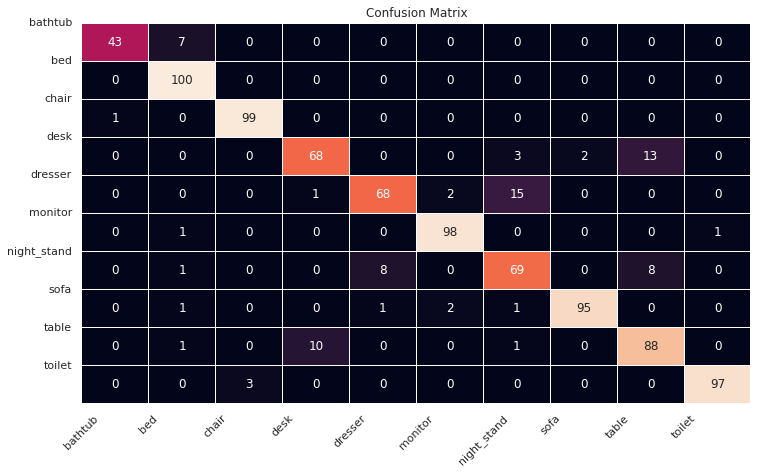

In [57]:
create_matrix(conf_matrix,class_names)

######History

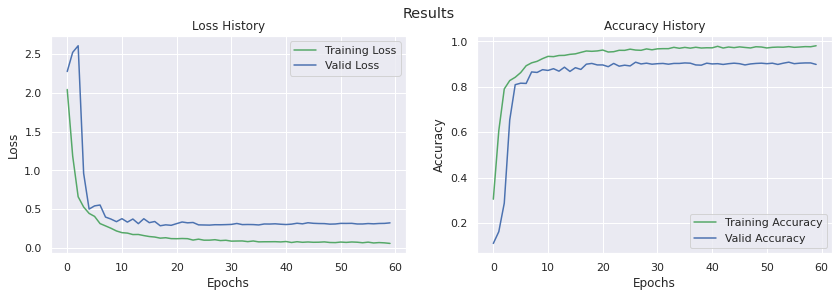

In [58]:
accurancy_and_loss_history(history)

###### Weight Histograms

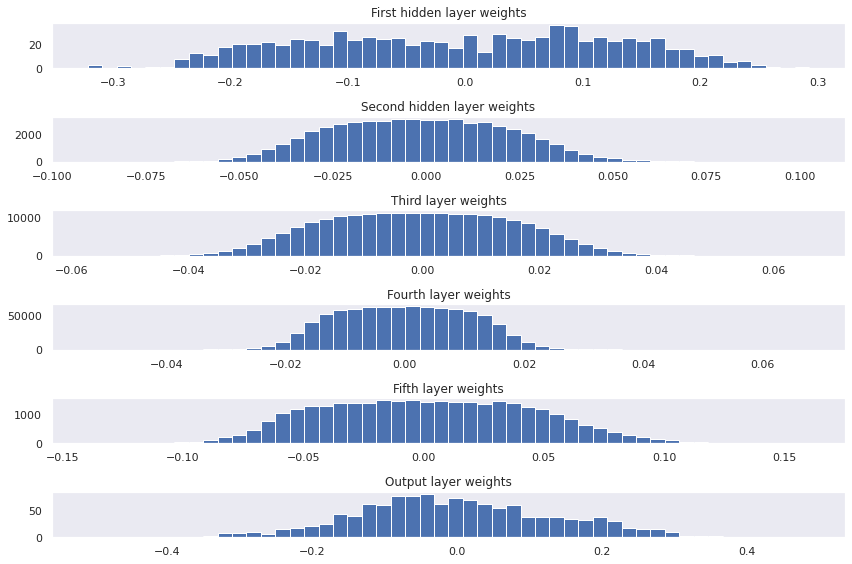

In [59]:
model_weights(model,4)

######Model Visualize

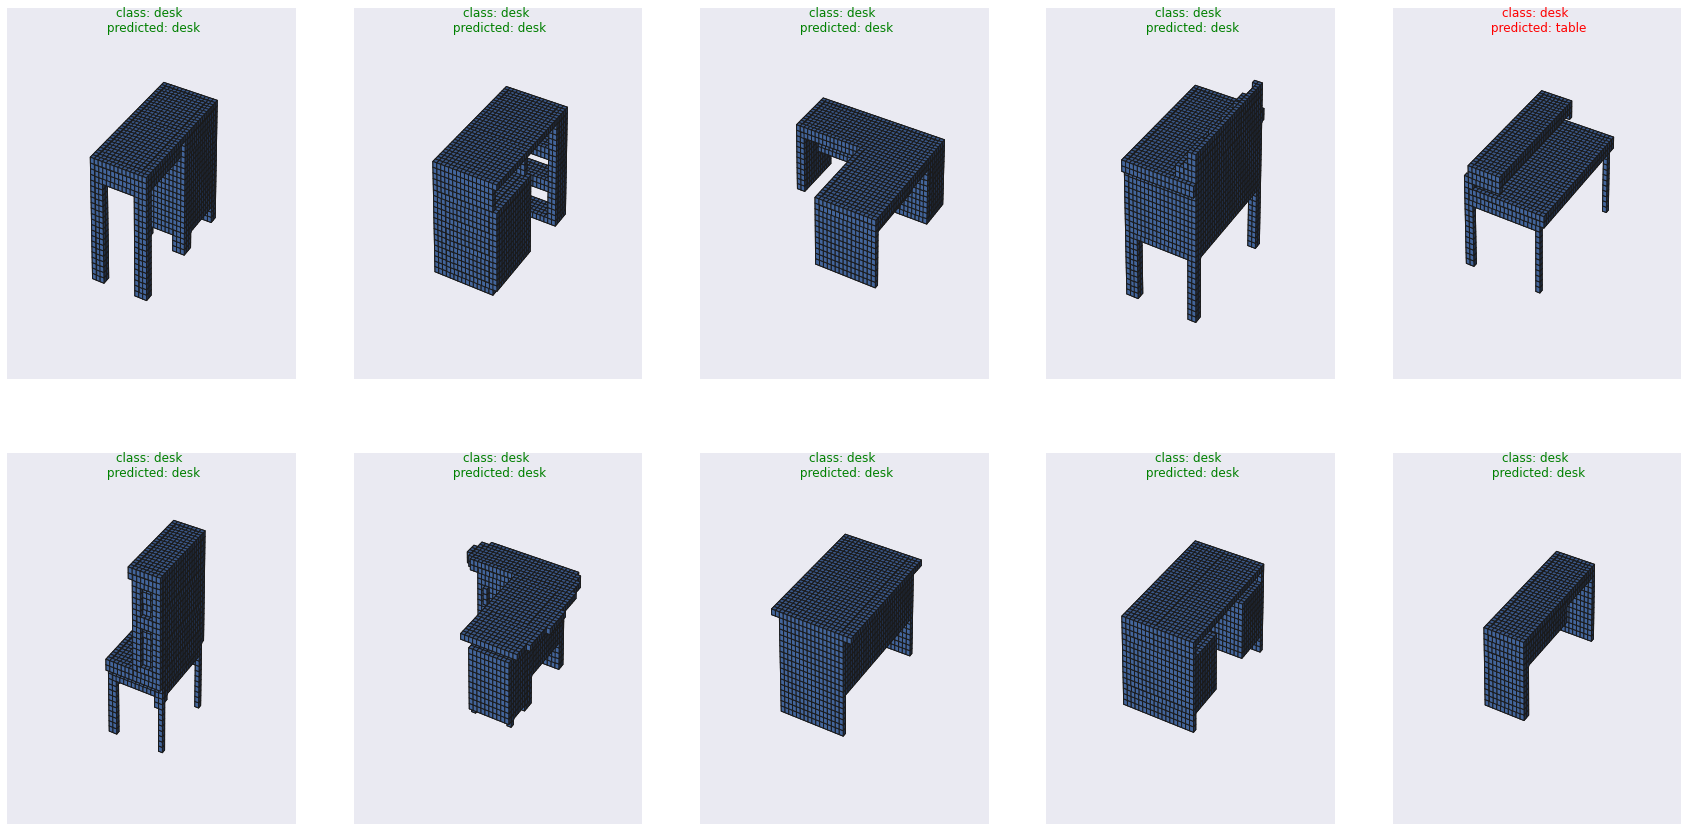

In [60]:
visualize_model(model, test_dataloader, class_names)

######Classification Report

In [61]:
print(classification_report(y_conf, pred, target_names =class_names))

              precision    recall  f1-score   support

     bathtub       0.98      0.86      0.91        50
         bed       0.90      1.00      0.95       100
       chair       0.97      0.99      0.98       100
        desk       0.86      0.79      0.82        86
     dresser       0.88      0.79      0.83        86
     monitor       0.96      0.98      0.97       100
 night_stand       0.78      0.80      0.79        86
        sofa       0.98      0.95      0.96       100
       table       0.81      0.88      0.84       100
      toilet       0.99      0.97      0.98       100

    accuracy                           0.91       908
   macro avg       0.91      0.90      0.90       908
weighted avg       0.91      0.91      0.91       908



In [ ]:
raise KeyboardInterrupt

#FAIL EXPERIENCES

##Batch After Relu

In [62]:
class Orion_batch_after_relu(nn.Module):
    def __init__(self,f1,f2,f3,f4,fc_1,p, n_classes=10, data_size=32,bnorms=None):
        super().__init__()
        self.n_classes = n_classes
        self.data_size = data_size
        self.f1 = f1
        self.f2 = f2
        self.f3=  f3
        self.f4=  f4
        self.fc_1 = fc_1
        self.p = p  # dropout ratios
        self.batch = bnorms
        
        #features
        self.conv3d_1 = nn.Conv3d(in_channels=1, out_channels=self.f1, kernel_size=(3,3,3), stride=2,padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(32)
        self.dropout1 = nn.Dropout(p=self.p[0])
        self.avgpool1 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))


        self.conv3d_2 = nn.Conv3d(in_channels=self.f1, out_channels=self.f2, kernel_size=(3,3,3), stride=1, padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        self.dropout2 = nn.Dropout(p=self.p[1])
        self.avgpool2 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
       
        self.conv3d_3 = nn.Conv3d(in_channels=f2, out_channels=self.f3, kernel_size=(3,3,3), stride=1, padding=(1, 1, 1))       
        self.bn3 = nn.BatchNorm3d(128)
        self.dropout3 = nn.Dropout(p=self.p[2])
        self.avgpool3 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        
        self.conv3d_4 = nn.Conv3d(in_channels=self.f3, out_channels=self.f4, kernel_size=(3,3,3), stride=1,padding=(1, 1, 1))
        self.bn4 = nn.BatchNorm3d(256)
        self.dropout4 = nn.Dropout(p=self.p[3])  
        self.avgpool4 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        
        
        if data_size==64:
            dim=351232
            351232
        else:
           dim=27648
            
        #calculate dim after pooling for fc layer
        x = torch.rand((1,1,data_size,data_size,data_size))
        x = self.conv3d_1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.avgpool1(x)

        x = self.conv3d_2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.avgpool2(x)

        x = self.conv3d_3(x)
        x = F.relu(x)
        x = self.bn3(x)      
        x = self.dropout3(x)
        x = self.avgpool3(x)

        x = self.conv3d_4(x)      
        x = F.relu(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.avgpool4(x)

        dim = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3] * x.shape[4]
        
        #mlp
        self.fc1 = nn.Linear(dim, fc_1)
        self.dropout5 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(self.fc_1, self.n_classes)
        #self.logsoftmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        #features
        x = self.conv3d_1(x)    
        x = F.relu(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        x = self.avgpool1(x)

        x = self.conv3d_2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.avgpool2(x)

        x = self.conv3d_3(x)     
        x = F.relu(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.avgpool3(x)

        x = self.conv3d_4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.avgpool4(x)
        
        #flatten
        x = x.view(x.size(0), -1)
        
        #mlp

        x= F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)
        
        return x

###### Network Init

In [63]:
batch_size=512

In [64]:
learning_rate = 0.1
data_size = 32
sgd_momentum = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 28
lr_scheduler_step = 28
lr_scheduler_gamma = 0.5
print_epoch_rate = 1
p = [0.2, 0.3, 0.4, 0.6, 0.4] # dropout ratios
#norms =[32, 64, 128, 256] #batch sizes
f= [32,64, 128, 256] # features
fc_1 = 128

In [65]:
n2 = Orion_batch_after_relu(f1=f[0],f2=f[1], f3=f[2], f4=f[3], fc_1=fc_1, p=p, n_classes=10, bnorms=None, data_size=32)
n2.get_parameter

<bound method Module.get_parameter of Orion_batch_after_relu(
  (conv3d_1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (avgpool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
  (conv3d_2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (avgpool2): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
  (conv3d_3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (avgpool3): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
  (conv3d_4): Conv3d(128, 256, kernel_size=

###### Optimizer & Loss Function 

In [66]:
optimizer = torch.optim.SGD(n.parameters(), lr=learning_rate, momentum=sgd_momentum)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=lr_scheduler_gamma)
loss_func = nn.CrossEntropyLoss()

######Train

In [67]:
train_dataloader, test_dataloader = load_data(batch_size=batch_size, augment=True)
conf_matrix, history,model,y_conf, pred = train(model=n2, epochs=epochs,loss_func=loss_func, \
                             train_dataloader=train_dataloader, test_dataloader=test_dataloader, \
                             optimizer=optimizer, lr_scheduler =lr_scheduler)


started training...

epoch:  1/ 28 train-loss: 2.31, train-acc: 12.25% valid-loss: 2.30, valid-acc: 11.01% time: 40.39 seconds
{'train loss': tensor(2.3052), 'epoch': 1}
{'valid loss': tensor(2.2975), 'epoch': 1}
{'train accuracy': 0.1224888414144516, 'epoch': 1}
{'valid accuracy': 0.11013215780258179, 'epoch': 1}
epoch:  2/ 28 train-loss: 2.31, train-acc: 11.94% valid-loss: 2.30, valid-acc: 11.01% time: 39.56 seconds
{'train loss': tensor(2.3063), 'epoch': 2}
{'valid loss': tensor(2.2975), 'epoch': 2}
{'train accuracy': 0.1194196417927742, 'epoch': 2}
{'valid accuracy': 0.11013215780258179, 'epoch': 2}
epoch:  3/ 28 train-loss: 2.30, train-acc: 11.02% valid-loss: 2.30, valid-acc: 11.01% time: 40.20 seconds
{'train loss': tensor(2.3050), 'epoch': 3}
{'valid loss': tensor(2.2983), 'epoch': 3}
{'train accuracy': 0.1102120503783226, 'epoch': 3}
{'valid accuracy': 0.11013215780258179, 'epoch': 3}
epoch:  4/ 28 train-loss: 2.31, train-acc: 11.41% valid-loss: 2.30, valid-acc: 7.16% time: 39.

#####Results

######Confusion Matrix

{'per class accuracy': {'bathtub': 0.0, 'bed': 0.0, 'chair': 100.0, 'desk': 0.0, 'dresser': 0.0, 'monitor': 0.0, 'night_stand': 0.0, 'sofa': 0.0, 'table': 0.0, 'toilet': 0.0}}


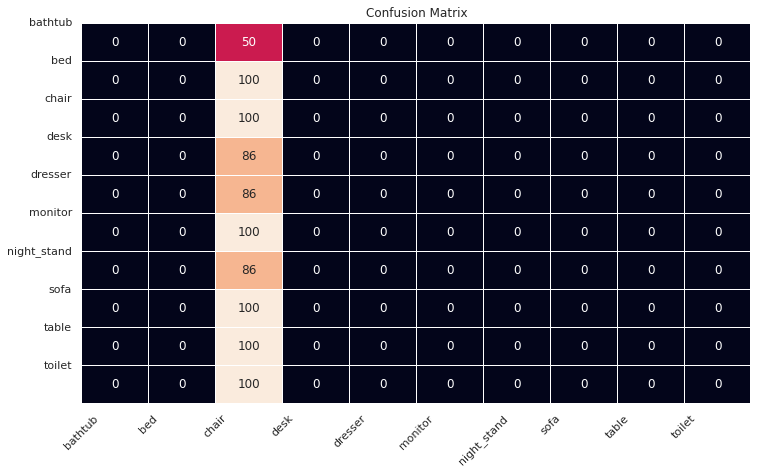

In [68]:
create_matrix(conf_matrix,class_names)

######History

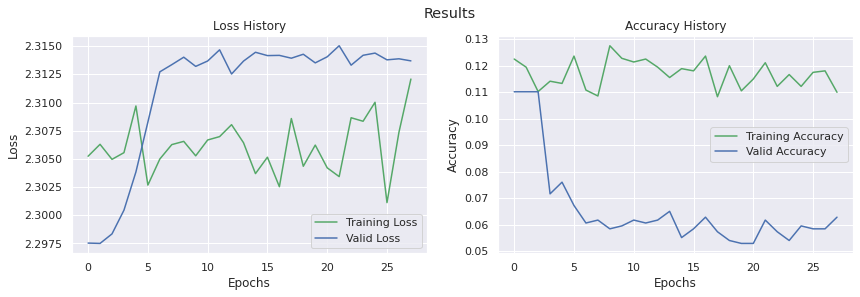

In [69]:
accurancy_and_loss_history(history)

###### Weight Histograms

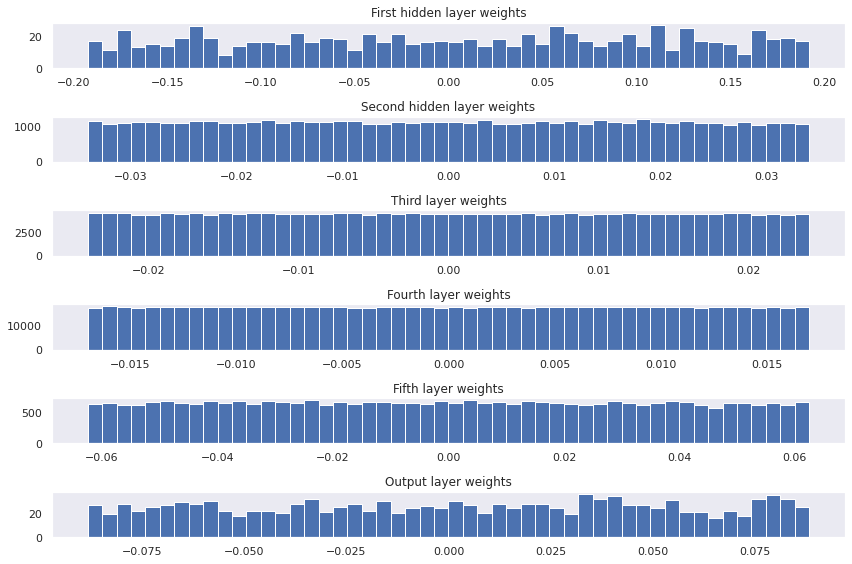

In [70]:
model_weights(model,4)

######Model Visualize

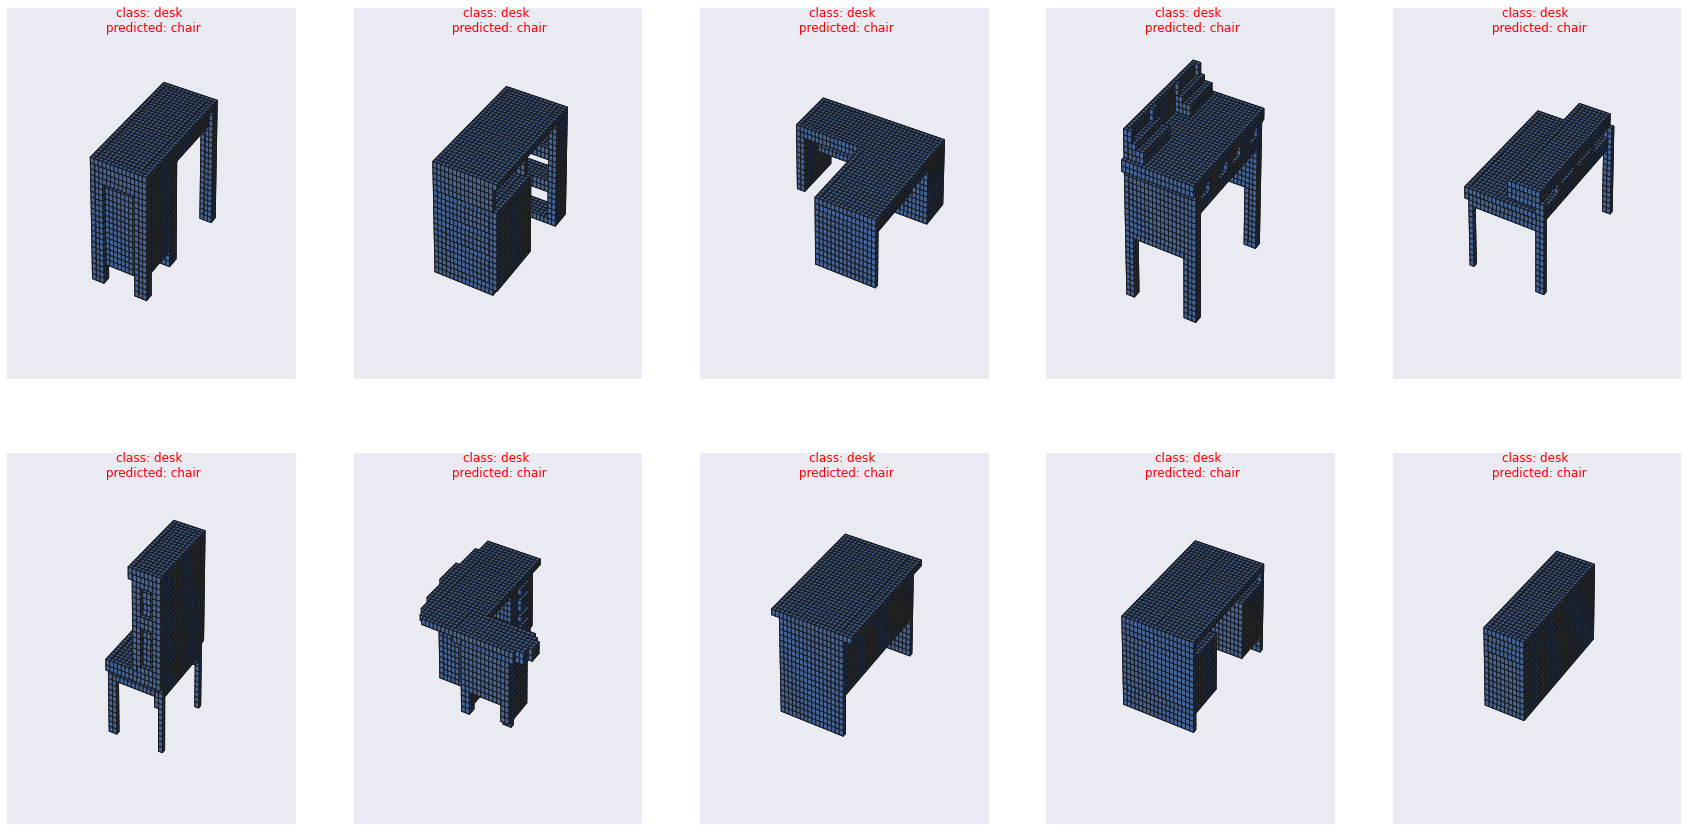

In [71]:
visualize_model(model, test_dataloader, class_names)

######Classification Report

In [72]:
print(classification_report(y_conf, pred, target_names =class_names))

              precision    recall  f1-score   support

     bathtub       0.00      0.00      0.00        50
         bed       0.00      0.00      0.00       100
       chair       0.11      1.00      0.20       100
        desk       0.00      0.00      0.00        86
     dresser       0.00      0.00      0.00        86
     monitor       0.00      0.00      0.00       100
 night_stand       0.00      0.00      0.00        86
        sofa       0.00      0.00      0.00       100
       table       0.00      0.00      0.00       100
      toilet       0.00      0.00      0.00       100

    accuracy                           0.11       908
   macro avg       0.01      0.10      0.02       908
weighted avg       0.01      0.11      0.02       908



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Pooling After CNN

In [26]:
class Orion_pool_after_cnn(nn.Module):
    def __init__(self,f1,f2,f3,f4,fc_1,p, n_classes=10, data_size=32,bnorms=None):
        super().__init__()
        self.n_classes = n_classes
        self.data_size = data_size
        self.f1 = f1
        self.f2 = f2
        self.f3=  f3
        self.f4=  f4
        self.fc_1 = fc_1
        self.p = p  # dropout ratios
        self.batch = bnorms
        
        #features
        self.conv3d_1 = nn.Conv3d(in_channels=1, out_channels=self.f1, kernel_size=(3,3,3), stride=2,padding=(1, 1, 1))
        self.avgpool1 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.bn1 = nn.BatchNorm3d(32)
        self.dropout1 = nn.Dropout(p=self.p[0])
        


        self.conv3d_2 = nn.Conv3d(in_channels=self.f1, out_channels=self.f2, kernel_size=(3,3,3), stride=1, padding=(1, 1, 1))
        self.avgpool2 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.bn2 = nn.BatchNorm3d(64)
        self.dropout2 = nn.Dropout(p=self.p[1])
        
       
        self.conv3d_3 = nn.Conv3d(in_channels=f2, out_channels=self.f3, kernel_size=(3,3,3), stride=1, padding=(1, 1, 1))       
        self.avgpool3 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.bn3 = nn.BatchNorm3d(128)
        self.dropout3 = nn.Dropout(p=self.p[2])
        

        
        self.conv3d_4 = nn.Conv3d(in_channels=self.f3, out_channels=self.f4, kernel_size=(3,3,3), stride=1,padding=(1, 1, 1))
        self.avgpool4 = nn.AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.bn4 = nn.BatchNorm3d(256)
        self.dropout4 = nn.Dropout(p=self.p[3])
          
        
        
        if data_size==64:
            dim=35123
            351232
        else:
           dim=27648
            
        #calculate dim after pooling for fc layer
        x = torch.rand((1,1,data_size,data_size,data_size))
        
        x = self.conv3d_1(x)
        
        #x = self.bn1(x)
        x = F.relu(x)     
        x = self.dropout1(x)
        x = self.avgpool1(x)
        

        x  =self.conv3d_2(x)
        
        #x = self.bn2(x)
        x = F.relu(x)        
        x = self.dropout2(x)
        x = self.avgpool2(x)
        

        x = self.conv3d_3(x)
        
        #x = self.bn3(x) 
        x= F.relu(x)          
        x = self.dropout3(x)
        x = self.avgpool3(x)

        x = self.conv3d_4(x)   
           
        #x = self.bn4(x)
        x= F.relu(x)       
        x = self.dropout4(x)
        x = self.avgpool4(x)

        
        dim = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3] * x.shape[4]
        
        #mlp
        self.fc1 = nn.Linear(dim, fc_1)
        self.dropout5 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(self.fc_1, self.n_classes)
        #self.logsoftmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        #features
        x = self.conv3d_1(x)
          
        #x = self.bn1(x)
        x = F.relu(x)
        x = self.avgpool1(x) 
        
        x = self.dropout1(x)
        
        x = self.conv3d_2(x)
        
        #x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.avgpool2(x)
        
        x =self.conv3d_3(x)
        
        #x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        x = self.avgpool3(x)
        
        x = self.conv3d_4(x)
          
        #x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x = self.avgpool4(x) 
        
        
        #flatten
        x = x.view(x.size(0), -1)
        
        #mlp

        x= F.relu(self.fc1(x))
        x = self.dropout5(x)
        x = self.fc2(x)
        
        return x

###### Network Init

In [31]:
batch_size=512

In [32]:
learning_rate = 0.1
data_size = 32
sgd_momentum = 0.9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 28
lr_scheduler_step = 28
lr_scheduler_gamma = 0.5
print_epoch_rate = 1
p = [0.2, 0.3, 0.4, 0.6, 0.4] # dropout ratios
#norms =[32, 64, 128, 256] #batch sizes
f= [32,64, 128, 256] # features
fc_1 = 128

In [33]:
n3 = Orion_pool_after_cnn(f1=f[0],f2=f[1], f3=f[2], f4=f[3], fc_1=fc_1, p=p, n_classes=10, bnorms=None, data_size=32)
n3.get_parameter

<bound method Module.get_parameter of Orion_pool_after_cnn(
  (conv3d_1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (avgpool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
  (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv3d_2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (avgpool2): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3d_3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (avgpool3): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
  (bn3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.4, inplace=False)
  (conv3d_4): Conv3d(128, 256, kernel_size=(3

###### Optimizer & Loss Function 

In [34]:
optimizer = torch.optim.SGD(n3.parameters(), lr=learning_rate, momentum=sgd_momentum)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=lr_scheduler_gamma)
loss_func = nn.CrossEntropyLoss()

######Train

In [43]:
train_dataloader, test_dataloader = load_data(batch_size=batch_size, augment=True)
conf_matrix, history,model,y_conf, pred = train(model=n3, epochs=epochs,loss_func=loss_func, \
                             train_dataloader=train_dataloader, test_dataloader=test_dataloader, \
                             optimizer=optimizer, lr_scheduler =lr_scheduler)


started training...

epoch:  1/ 28 train-loss: 2.27, train-acc: 18.28% valid-loss: 2.28, valid-acc: 11.01% time: 36.20 seconds
{'train loss': tensor(2.2672), 'epoch': 1}
{'valid loss': tensor(2.2807), 'epoch': 1}
{'train accuracy': 0.1827566921710968, 'epoch': 1}
{'valid accuracy': 0.11013215780258179, 'epoch': 1}
epoch:  2/ 28 train-loss: 2.18, train-acc: 22.32% valid-loss: 2.32, valid-acc: 11.01% time: 31.49 seconds
{'train loss': tensor(2.1814), 'epoch': 2}
{'valid loss': tensor(2.3185), 'epoch': 2}
{'train accuracy': 0.2232142835855484, 'epoch': 2}
{'valid accuracy': 0.11013215780258179, 'epoch': 2}
epoch:  3/ 28 train-loss: 2.15, train-acc: 22.18% valid-loss: 2.38, valid-acc: 11.01% time: 33.25 seconds
{'train loss': tensor(2.1457), 'epoch': 3}
{'valid loss': tensor(2.3830), 'epoch': 3}
{'train accuracy': 0.2218191921710968, 'epoch': 3}
{'valid accuracy': 0.11013215780258179, 'epoch': 3}
epoch:  4/ 28 train-loss: 2.15, train-acc: 22.04% valid-loss: 2.37, valid-acc: 11.01% time: 31

#####Results

######Confusion Matrix

{'per class accuracy': {'bathtub': 0.0, 'bed': 0.0, 'chair': 100.0, 'desk': 0.0, 'dresser': 0.0, 'monitor': 0.0, 'night_stand': 0.0, 'sofa': 0.0, 'table': 0.0, 'toilet': 0.0}}


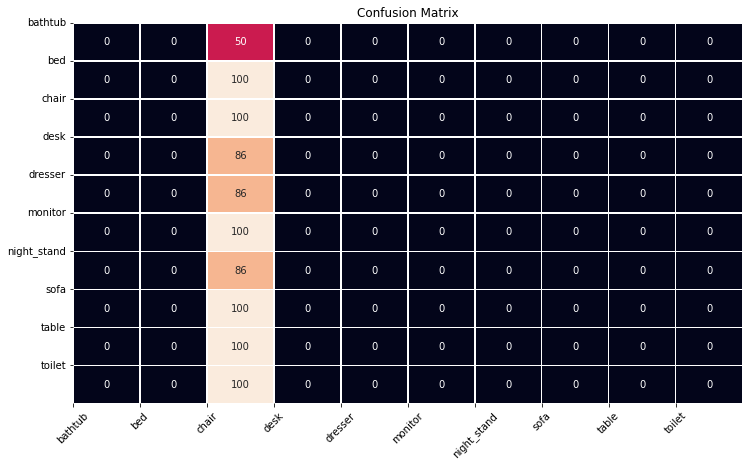

In [44]:
create_matrix(conf_matrix,class_names)

######History

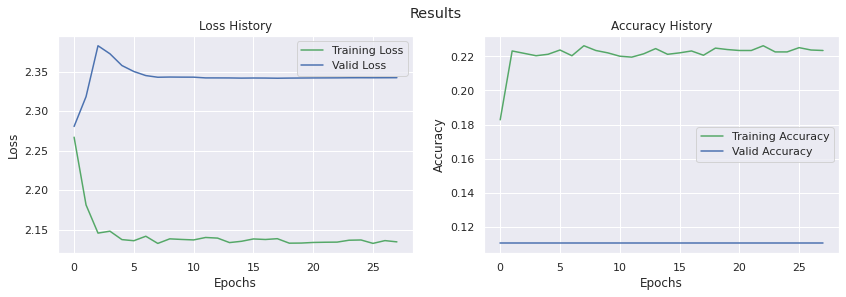

In [45]:
accurancy_and_loss_history(history)

###### Weight Histograms

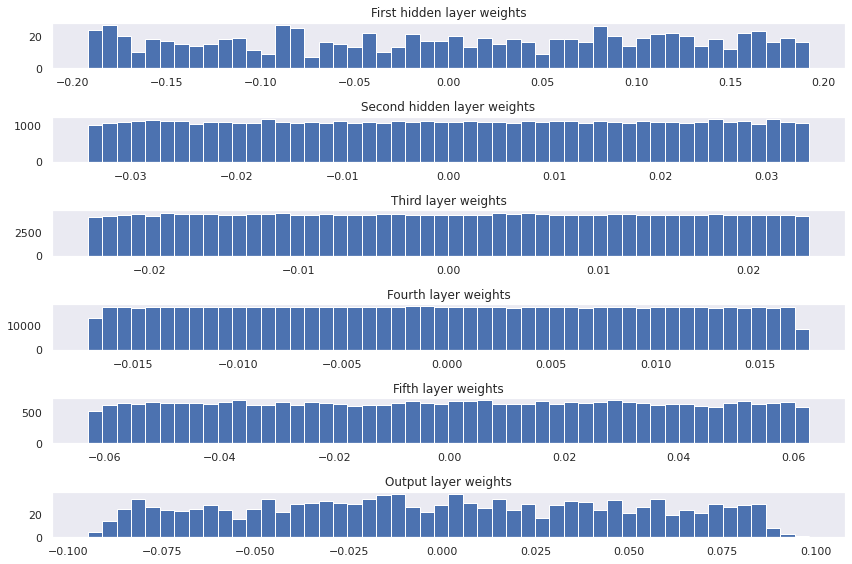

In [46]:
model_weights(model,4)

######Model Visualize

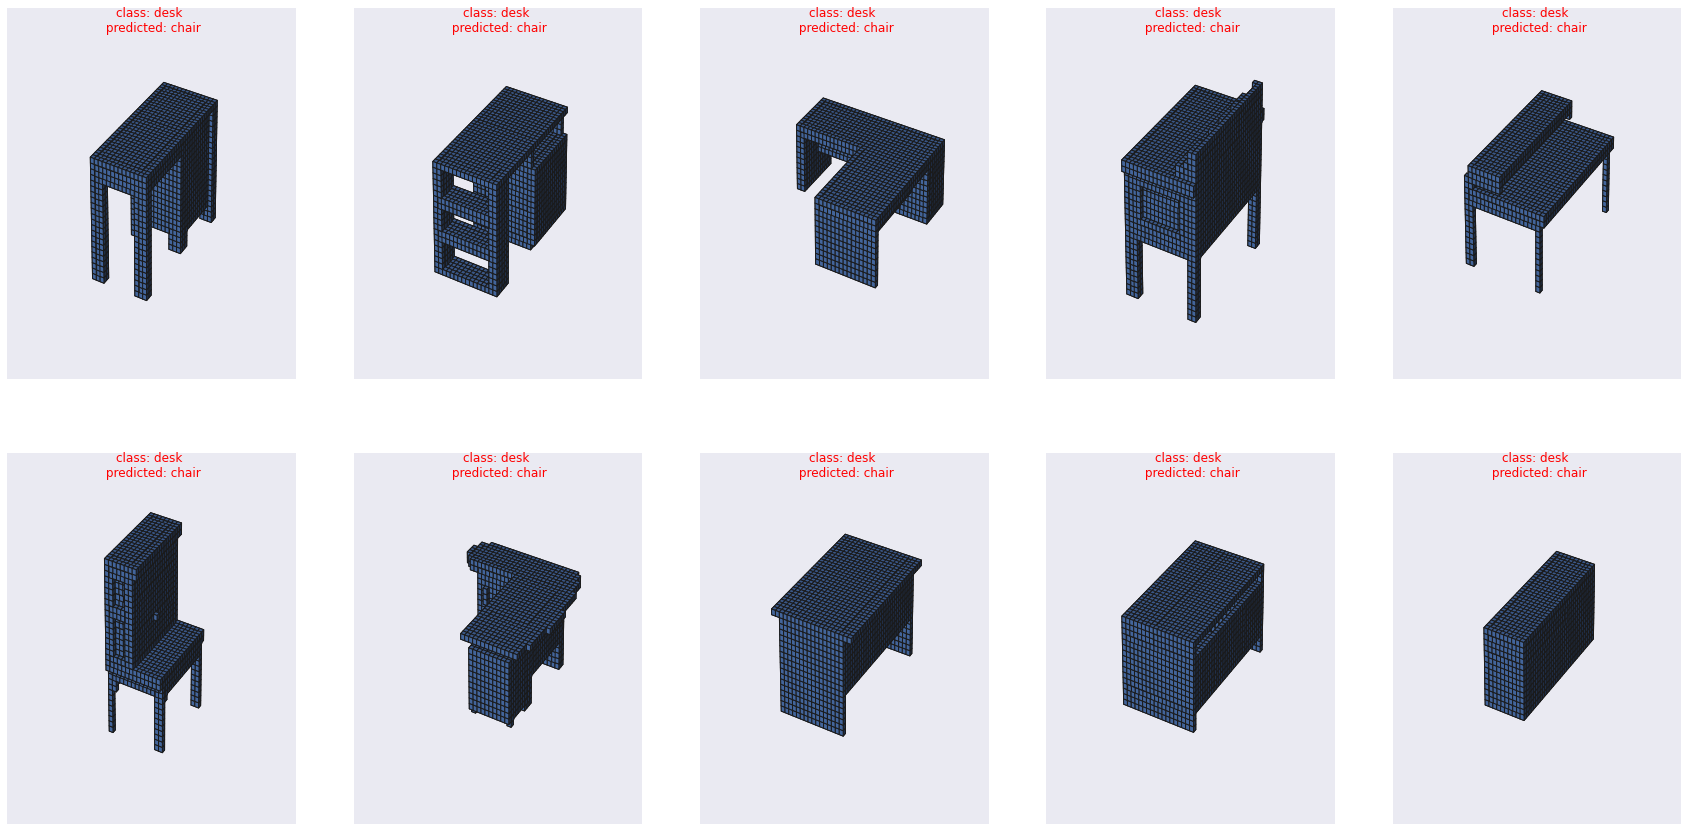

In [47]:
visualize_model(model, test_dataloader, class_names)

######Classification Report

In [48]:
print(classification_report(y_conf, pred, target_names =class_names))

              precision    recall  f1-score   support

     bathtub       0.00      0.00      0.00        50
         bed       0.00      0.00      0.00       100
       chair       0.11      1.00      0.20       100
        desk       0.00      0.00      0.00        86
     dresser       0.00      0.00      0.00        86
     monitor       0.00      0.00      0.00       100
 night_stand       0.00      0.00      0.00        86
        sofa       0.00      0.00      0.00       100
       table       0.00      0.00      0.00       100
      toilet       0.00      0.00      0.00       100

    accuracy                           0.11       908
   macro avg       0.01      0.10      0.02       908
weighted avg       0.01      0.11      0.02       908



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
